In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np


file_uri = 'D:\Work\Home-2023\may-project\labs\outputsx\merged\merged_บ้านสบป้าด.csv.csv'

# Load the dataset
data = pd.read_csv(file_uri)
data['Datetime'] = pd.to_datetime(data['Datetime'])


# Select relevant features (assuming 'SO2' is your target)
features = ['Value_TEMP', 'Value_RH', 'Value_SO2', 'Value_NO2', 'Value_PM10']
features = ['ValueLn_NO2', 'ValueLn_PM10', 'ValueLn_RH', 'ValueLn_TEMP', 'ValueLn_TSP']
# features = ['ValueLn_BP', 'ValueLn_DEV', 'ValueLn_NO2', 'ValueLn_PM10', 'ValueLn_RAIN', 'ValueLn_RH', 'ValueLn_SO2_1', 'ValueLn_SW', 'ValueLn_TEMP', 'ValueLn_TSP', 'ValueLn_WD', 'ValueLn_WS']
data_selected = data[features]

# Fill missing values if needed
data_selected = data_selected.interpolate(method='linear')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_selected)

# Function to create dataset for LSTM
def create_dataset(dataset, look_back=48):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0:-1]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

# Prepare data for LSTM
look_back = 48
X, y = create_dataset(data_scaled, look_back)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


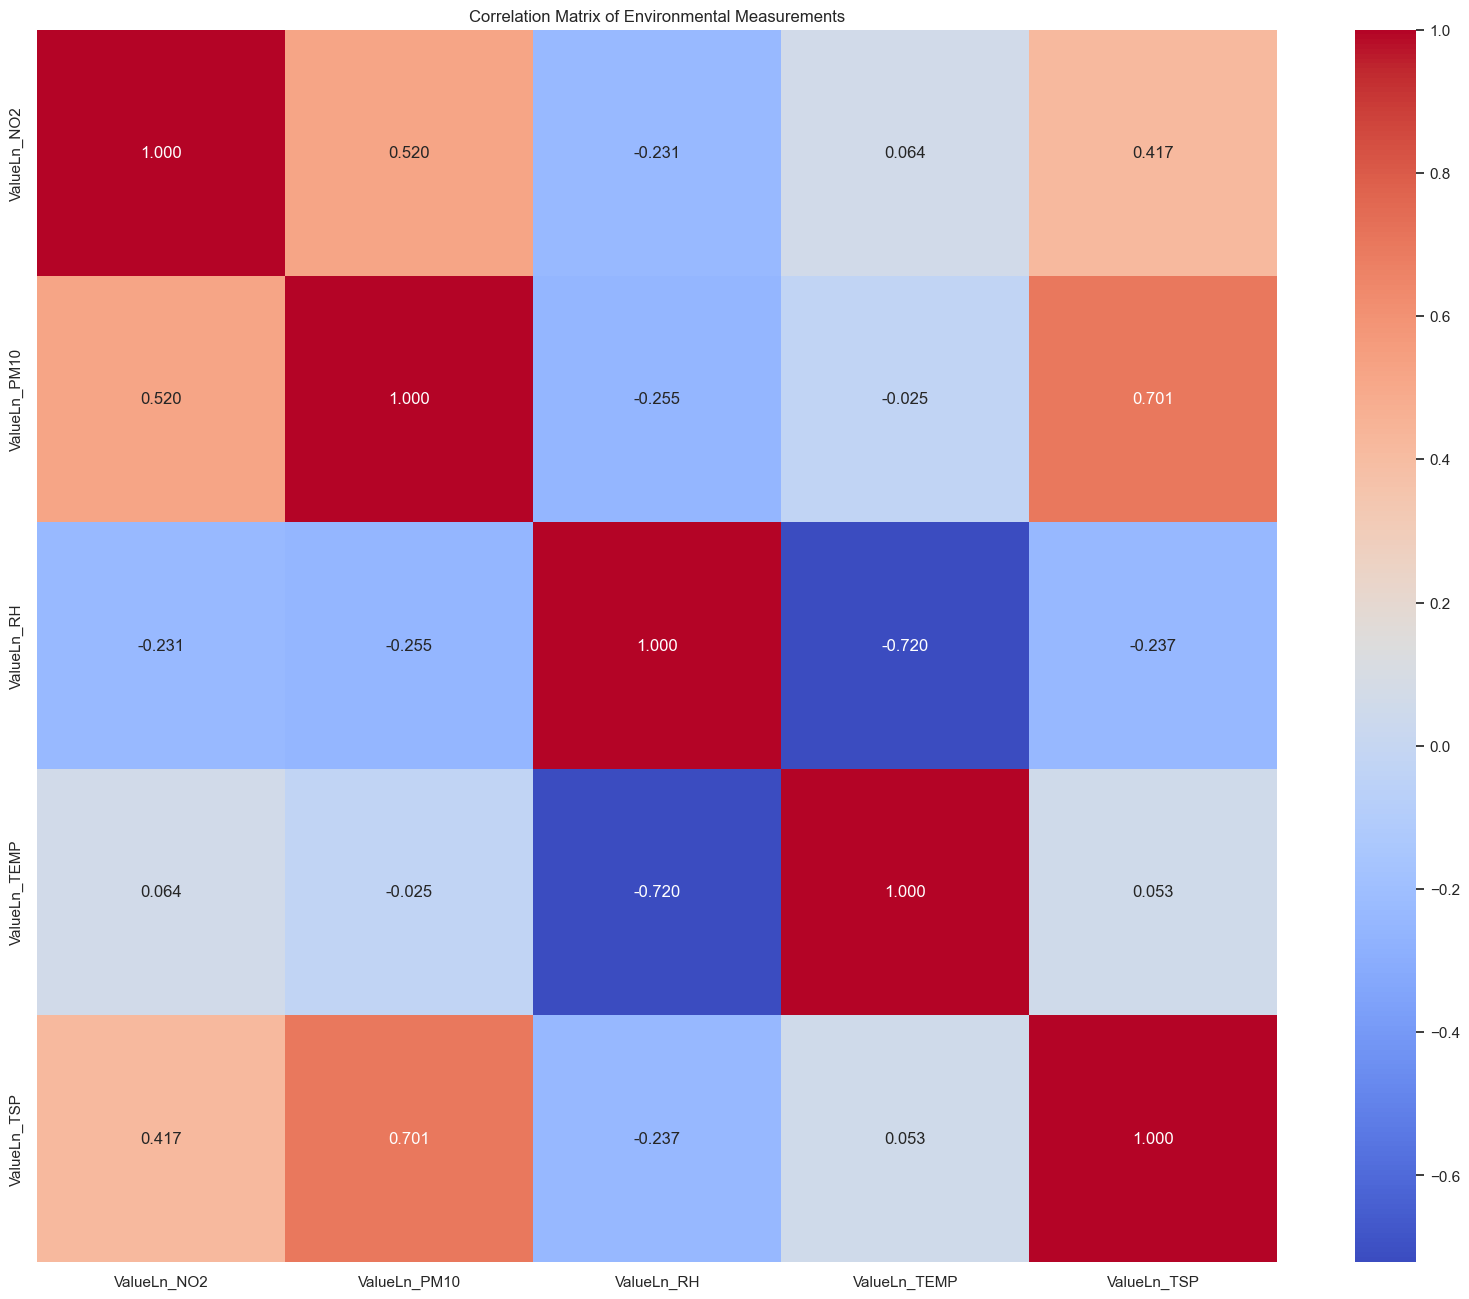

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Exclude non-numeric columns (like 'Datetime') from the correlation calculation
numeric_data = data_selected.select_dtypes(include=[np.number])

# Fill missing values with the median (or your preferred method)
numeric_data = numeric_data.fillna(numeric_data.median())

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Set the aesthetics for the plots (optional but recommended for better visuals)
sns.set(style="white")

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap='coolwarm')
plt.title("Correlation Matrix of Environmental Measurements")
plt.show()


In [9]:

# # Identifying features highly correlated with SO2
# # Adjust the threshold as needed
# threshold = 0.1
# highly_correlated_features = correlation_matrix['ValueLn_SO2'].abs() > threshold
# print("Features strongly correlated with SO2:")
# print(correlation_matrix['ValueLn_SO2'][highly_correlated_features].sort_values(ascending=False))

In [10]:
print(X_train.shape)
X_train

(84114, 48, 4)


array([[[0.03174603, 0.046875  , 0.92929293, 0.52182718],
        [0.03174603, 0.046875  , 0.91919192, 0.53375338],
        [0.01587302, 0.02232143, 0.87878788, 0.54792979],
        ...,
        [0.        , 0.01785714, 0.94949495, 0.53937894],
        [0.        , 0.02008929, 0.94949495, 0.53712871],
        [0.        , 0.02901786, 0.94949495, 0.53465347]],

       [[0.        , 0.05580357, 1.        , 0.47547255],
        [0.        , 0.06026786, 0.98989899, 0.46984698],
        [0.        , 0.05580357, 0.98989899, 0.46332133],
        ...,
        [0.01587302, 0.04241071, 1.        , 0.51710171],
        [0.01587302, 0.04241071, 1.        , 0.51372637],
        [0.        , 0.03571429, 1.        , 0.50922592]],

       [[0.03174603, 0.08482143, 0.80808081, 0.4009901 ],
        [0.01587302, 0.06026786, 0.80808081, 0.4009901 ],
        [0.        , 0.04464286, 0.80808081, 0.4009901 ],
        ...,
        [0.07142857, 0.17410714, 0.80808081, 0.4009901 ],
        [0.01587302, 0.158482

In [11]:
print(y_train.shape)
y_train

(84114,)


array([0.05150977, 0.05328597, 0.11367673, ..., 0.06749556, 0.18294849,
       0.01420959])

In [20]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense

# GPU configuration (optional, for fine-tuning performance)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Rest of your model code
model = Sequential()

print(X_train.shape[1], X_train.shape[2])

model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model.add(LSTM(50, activation='tanh', recurrent_activation='sigmoid'))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)



48 4
Epoch 1/20
1169/1169 - 15s - loss: 0.0046 - val_loss: 0.0042 - 15s/epoch - 13ms/step
Epoch 2/20
1169/1169 - 13s - loss: 0.0041 - val_loss: 0.0041 - 13s/epoch - 11ms/step
Epoch 3/20
1169/1169 - 13s - loss: 0.0040 - val_loss: 0.0040 - 13s/epoch - 11ms/step
Epoch 4/20
1169/1169 - 13s - loss: 0.0040 - val_loss: 0.0040 - 13s/epoch - 11ms/step
Epoch 5/20
1169/1169 - 13s - loss: 0.0038 - val_loss: 0.0039 - 13s/epoch - 11ms/step
Epoch 6/20
1169/1169 - 13s - loss: 0.0037 - val_loss: 0.0038 - 13s/epoch - 11ms/step
Epoch 7/20
1169/1169 - 13s - loss: 0.0036 - val_loss: 0.0038 - 13s/epoch - 11ms/step
Epoch 8/20
1169/1169 - 13s - loss: 0.0035 - val_loss: 0.0036 - 13s/epoch - 11ms/step
Epoch 9/20
1169/1169 - 12s - loss: 0.0034 - val_loss: 0.0035 - 12s/epoch - 11ms/step
Epoch 10/20
1169/1169 - 12s - loss: 0.0033 - val_loss: 0.0034 - 12s/epoch - 10ms/step
Epoch 11/20
1169/1169 - 13s - loss: 0.0031 - val_loss: 0.0034 - 13s/epoch - 11ms/step
Epoch 12/20
1169/1169 - 14s - loss: 0.0030 - val_loss: 0.0

In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions
y_pred = model.predict(X_test)

# Invert scaling for prediction - We need to create a dummy array with the same shape as the input features
y_pred_rescaled = np.concatenate((np.zeros((y_pred.shape[0], data_scaled.shape[1]-1)), y_pred), axis=1)
y_pred_inv = scaler.inverse_transform(y_pred_rescaled)[:, -1]  # Select only the last column (SO2)

# Invert scaling for actual values
y_test_rescaled = np.concatenate((np.zeros((y_test.shape[0], data_scaled.shape[1]-1)), y_test.reshape(-1, 1)), axis=1)
y_test_inv = scaler.inverse_transform(y_test_rescaled)[:, -1]  # Select only the last column (SO2)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('Test RMSE: %.3f' % rmse)


658/658 [==============================] - 4s 5ms/step
Test RMSE: 27.687


1/1 [==============================] - 0s 19ms/step


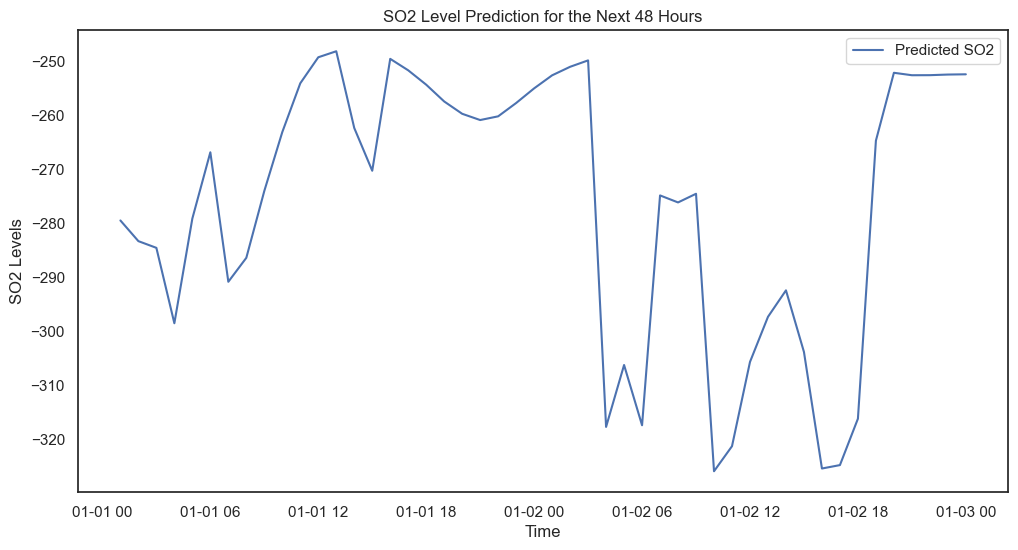

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'data' is your original DataFrame and 'model' is your trained LSTM model

predicted_SO2 = []
input_data = data_scaled[-look_back:]  # Initial input data

for i in range(48):  # Predicting 48 steps
    # Reshape and predict
    input_data_reshaped = np.reshape(input_data, (1, look_back, data_scaled.shape[1]))
    prediction = model.predict(input_data_reshaped)

    # Inverse scale the prediction and append to results
    prediction_rescaled = np.concatenate((np.zeros((prediction.shape[0], data_scaled.shape[1]-1)), prediction), axis=1)
    prediction_SO2 = scaler.inverse_transform(prediction_rescaled)[:, -1]
    predicted_SO2.append(prediction_SO2[0])

    # Construct a new row for input_data
    new_row = np.concatenate((input_data[-1, 1:], prediction[0]))  # Combine last features and new prediction
    input_data = np.vstack((input_data[1:], new_row))  # Replace oldest row with new row

# Generate timestamps for the next 48 hours
predicted_timestamps = pd.date_range(start=data['Datetime'].iloc[-1], periods=49, freq='H')[1:]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(predicted_timestamps, predicted_SO2, label='Predicted SO2')
plt.xlabel('Time')
plt.ylabel('SO2 Levels')
plt.title('SO2 Level Prediction for the Next 48 Hours')
plt.legend()
plt.show()


1/1 [==============================] - 0s 22ms/step


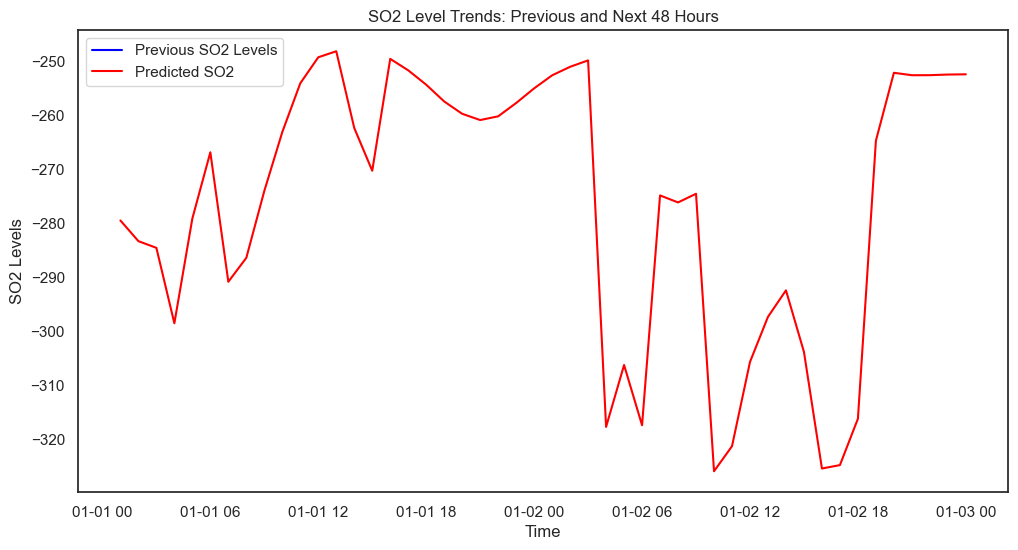

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert 'Datetime' to pandas datetime if it's not already
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Plot previous data - adjust the number of rows as needed
plt.figure(figsize=(12, 6))
plt.plot(data['Datetime'][-look_back:], data['Value_SO2'][-look_back:], label='Previous SO2 Levels', color='blue')

# Initialize list to store predicted SO2 levels
predicted_SO2 = []

# Use the last part of your scaled data as input for predictions
input_data = data_scaled[-look_back:]  # Initial input data


for i in range(48):  # Predicting 48 steps
    # Reshape and predict
    input_data_reshaped = np.reshape(input_data, (1, look_back, data_scaled.shape[1]))
    prediction = model.predict(input_data_reshaped)

    # Ensure dimension match for concatenation
    zeros_shape = (prediction.shape[0], data_scaled.shape[1] - prediction.shape[1])
    prediction_rescaled = np.concatenate((np.zeros(zeros_shape), prediction), axis=1)
    
    # Inverse scale the prediction and append to results
    prediction_SO2 = scaler.inverse_transform(prediction_rescaled)[:, -1]
    predicted_SO2.append(prediction_SO2[0])

    # Construct a new row for input_data
    new_row = np.concatenate((input_data[-1, 1:], prediction[0]))  # Combine last features and new prediction
    input_data = np.vstack((input_data[1:], new_row))  # Replace oldest row with new row


# Generate timestamps for the next 48 hours
predicted_timestamps = pd.date_range(start=data['Datetime'].iloc[-1], periods=49, freq='H')[1:]

# Plot predicted data
plt.plot(predicted_timestamps, predicted_SO2, label='Predicted SO2', color='red')

# Finalizing the plot
plt.xlabel('Time')
plt.ylabel('SO2 Levels')
plt.title('SO2 Level Trends: Previous and Next 48 Hours')
plt.legend()
plt.show()



In [16]:
import numpy as np

# Predict the next 2 days of SO2 values for the test data
predicted_values = model.predict(X_test)

# Invert scaling for prediction
# Create a dummy array with zeros to match the shape expected by scaler.inverse_transform
dummy_array = np.zeros((predicted_values.shape[0], data_scaled.shape[1] - 1))
predicted_values_padded = np.concatenate((dummy_array, predicted_values), axis=1)

# Apply inverse_transform and extract the relevant column
predicted_SO2 = scaler.inverse_transform(predicted_values_padded)[:, -1]

# Invert scaling for actual values (y_test)
# Repeat the same process for y_test
y_test_padded = np.concatenate((dummy_array, y_test.reshape(-1, 1)), axis=1)
actual_SO2 = scaler.inverse_transform(y_test_padded)[:, -1]



  1/658 [..............................] - ETA: 12s

658/658 [==============================] - 3s 5ms/step


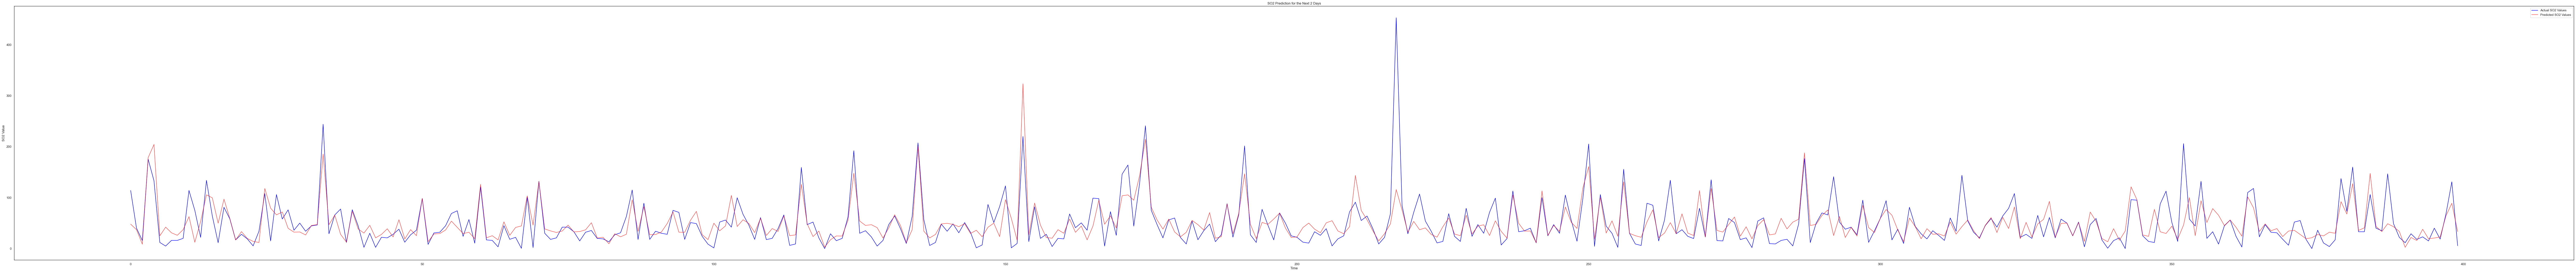

In [19]:
# Plot the results
import matplotlib.pyplot as plt

prev_view = -400


plt.figure(figsize=(160, 16))
time_steps = np.arange(len(actual_SO2[prev_view:]))
plt.plot(actual_SO2[prev_view:], label="Actual SO2 Values", color="blue", linestyle='-')
plt.plot( predicted_SO2[prev_view:], label="Predicted SO2 Values", color="red", alpha=0.7, linestyle='-')

plt.title("SO2 Prediction for the Next 2 Days")
plt.xlabel("Time")
plt.ylabel("SO2 Value")
plt.legend()
plt.savefig('predict.png')
plt.show()


In [18]:

print(len(predicted_SO2))
print(len(actual_SO2))

21029
21029
